In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info

Implementation is based on https://www.dsprelated.com/showarticle/58.php. This core implements the Dual-DC removal. The paper also discusses the Quad-DC removal, but my tests show it gives only slight improvement for alot of BRAM (only consider if you care about passband ripple..).
Works on 18-bit signed fixed-point numbers. Inputs and outputs assumed to be in range of -1 to 1. Outliers are saturated.

## Selection of ``window_len``
You want this to be infinite, as it makes the stopband sharper. OTOH this also controls how much BRAM you are using. 1024 is a nice value.

## On output width
This block outputs in 18-bit format, but usual usecase is to round it back to 12 bits (which is a common SDR size). Be warned that in this case DC **cannot** be removed if it is < ~80 dBm. I would suggest ~16 bits output for a reliable operation.

# Examples

## Remove DC component from complex signal

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 513/513 [00:00<00:00, 9566.16it/s]
INFO:sim:Flushing the pipeline to collect 513 valid samples (currently have 508)
INFO:sim:Hardware delay is 5


<IPython.core.display.Javascript object>


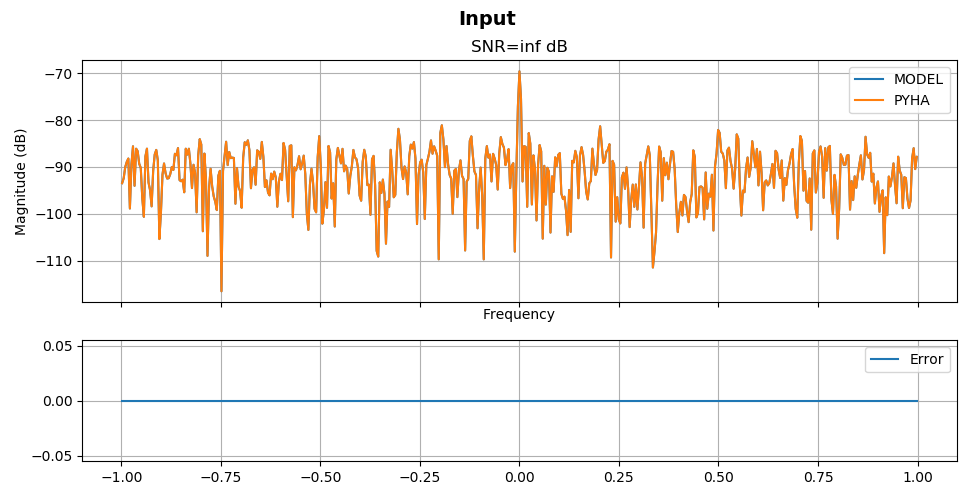

<IPython.core.display.Javascript object>


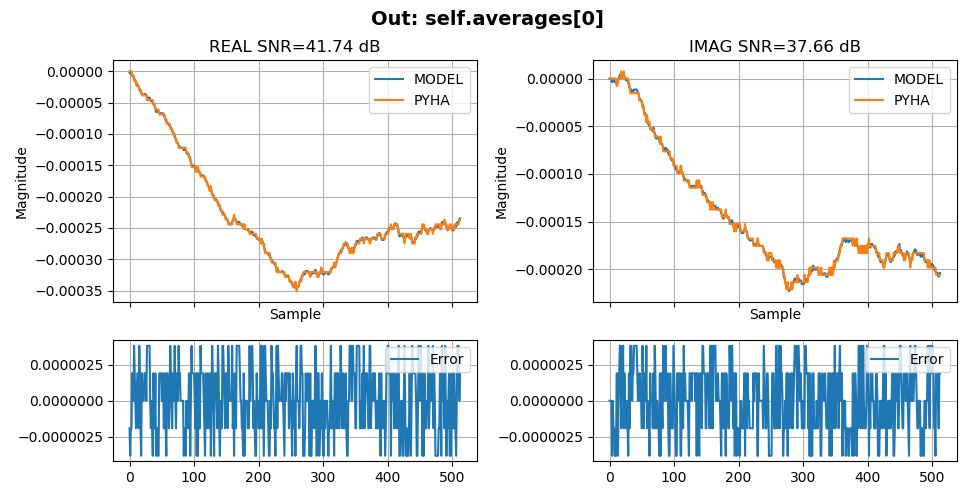

<IPython.core.display.Javascript object>


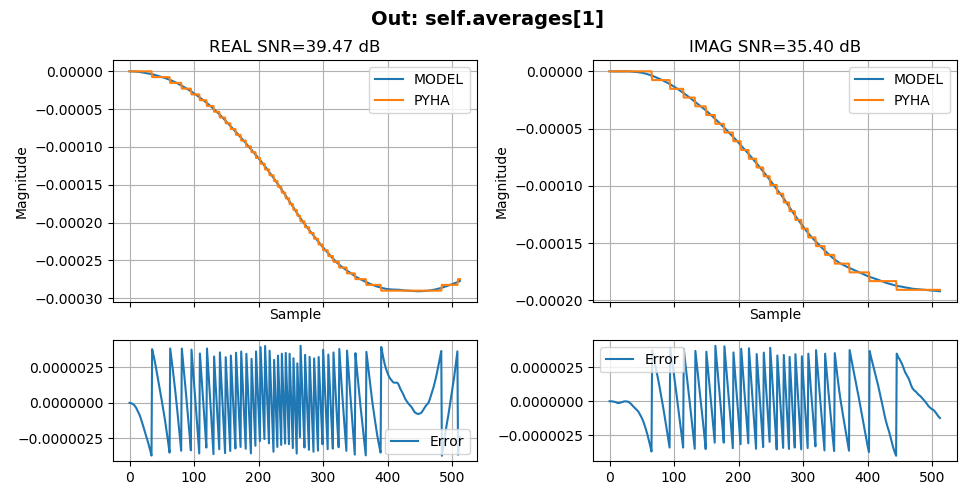

<IPython.core.display.Javascript object>


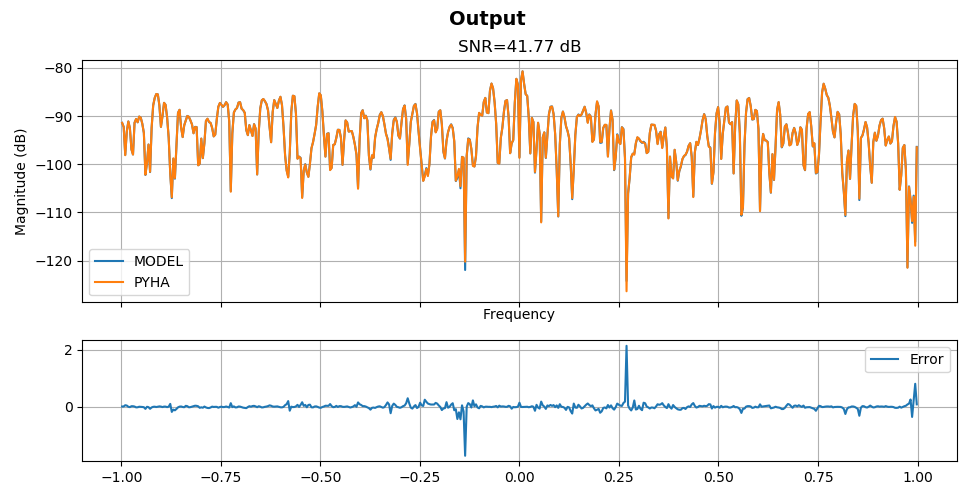

In [43]:
# file = get_data_file('dcspike_bladerf_20m.complex64')
file = get_data_file('from_tap.raw')
# file = get_data_file('gqrx_20180910_155357_2400499992_2999999_fc.raw')


input_signal = load_complex64_file(file) # IQ samples

dut = DCRemoval(window_len=256, dtype=Complex)
sim = Simulator(dut, trace=True).run(input_signal) # run simulations and gather trace
sim.plot_trace(mode={'Input': 'frequency', 'Output': 'frequency'})
# sim.plot_trace(mode={'Input': 'frequency', 'Output': 'frequency'}, skip_first_n=1024*2)

## Frequency response

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 16384/16384 [00:01<00:00, 10277.88it/s]
INFO:sim:Flushing the pipeline to collect 16384 valid samples (currently have 16379)
INFO:sim:Hardware delay is 5


<IPython.core.display.Javascript object>


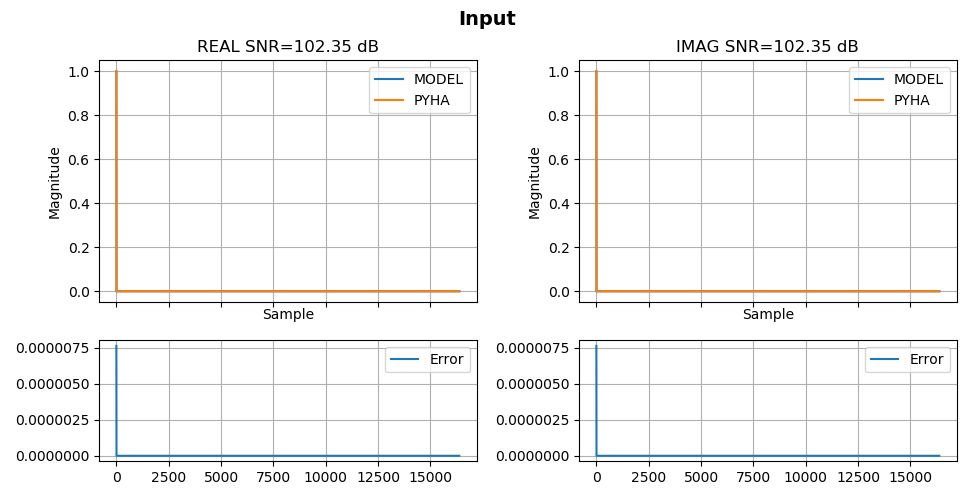

<IPython.core.display.Javascript object>


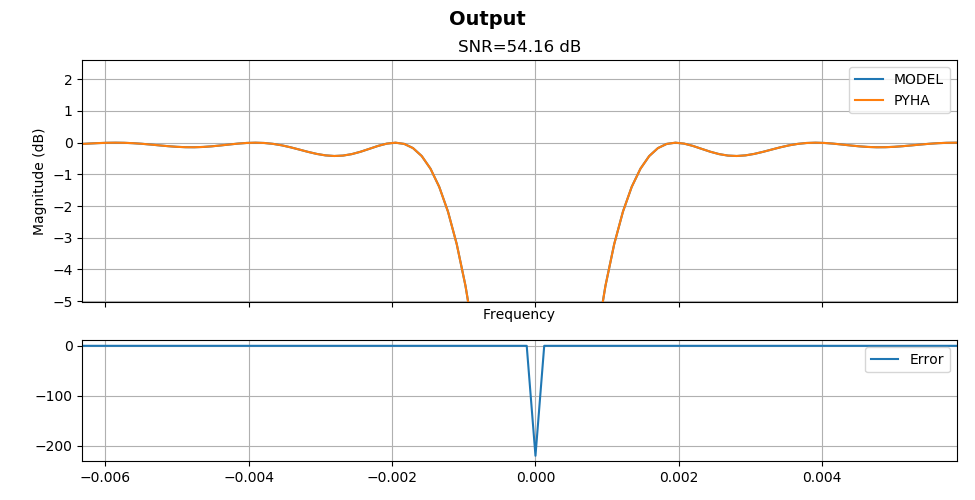

In [40]:
# NBVAL_IGNORE_OUTPUT
# taps 256 stopband  = -0.004 to 0.004
# taps 512 stopband  = -0.002 to 0.002
# taps 1024 stopband = -0.001 to 0.001
# reference one bin of 1024 point FFT is about 0.001, so 1024 taps clears 2 bins
input_signal = [0.0 + 0.0j] * 1024 * 16
input_signal[0] = 1.0 + 1.0j
dut = DCRemoval(window_len=1024, dtype=Complex)
sim = Simulator(dut, trace=True).run(input_signal)
sim.plot_trace(mode={'Input': 'time', 'Output': 'frequency_response'}, inout_only=True)

# Conversion to VHDL and RTL/NETLIST simulations

In [5]:
# Pyha design can be converted to VHDL after the PYHA simulation has been ran
# VHDL sources can be used to run the RTL simulation, in addition NETLIST simulation is supported (after Quartus mapper)
# Pyha automatically manages everything needed if you specify the 'RTL', 'NETLIST' flags.
output_dir = '~/Documents/pyha_output'
input_signal = (np.random.normal(size=1024) + np.random.normal(size=1024) * 1j) * 0.25
dut = DCRemoval(window_len=256)
vhdl_sim = Simulator(dut, output_dir=output_dir, extra_simulations=['RTL', 'NETLIST']).run(input_signal)
vhdl_sim.assert_equal(atol=1e-5, rtol=1e-5)

INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 1024/1024 [00:00<00:00, 1672.87it/s]
INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 1019)
INFO:sim:Hardware delay is 5
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:MovingAverage to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DCRemoval to VHDL ...
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 1029/1029 [00:00<00:00, 1154.25it/s]

INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
INFO:synth:Running quartus_eda quartus_project...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 102

# Synthesis:  resource usage and Fmax

In [6]:
print(vhdl_sim.quartus.get_resource_usage('fit'))
print(vhdl_sim.quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 529 / 39,600 ( 1 % )
    Total combinational functions : 392 / 39,600 ( < 1 % )
    Dedicated logic registers : 395 / 39,600 ( < 1 % )
Total registers : 395
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 18,252 / 1,161,216 ( 2 % )
Embedded Multiplier 9-bit elements : 0 / 232 ( 0 % )
Total PLLs : 0 / 4 ( 0 % )

+--------------------------------------------------+
; Fmax Summary                                     ;
+------------+-----------------+------------+------+
; Fmax       ; Restricted Fmax ; Clock Name ; Note ;
+------------+-----------------+------------+------+
; 170.27 MHz ; 170.27 MHz      ; clk        ;      ;
+------------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by